In [3]:
import sys

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from water_batch import WaterBatch
sys.path.append('..')
import dataset
from dataset import B,V,F, FilesIndex, Dataset, Pipeline
from dataset.dataset.models.tf import ResNet50

In [29]:
def concatenate_water(batch, model, return_targets=True):
    _ = model
    x = np.concatenate(np.concatenate(batch.sepcrop))
    x = x.reshape(batch.sepcrop.shape[0]*8, 64, 32, 3)
    y = np.concatenate(batch.labels).reshape(-1)
    
#     split_indices = np.cumsum([item.sepcrop.shape[0] for item in batch])[:-1]
    res_dict = {"feed_dict": {"images": x, "labels": y}}
#     if return_targets:
#         y = np.concatenate([np.tile(item.target, (item.signal.shape[0], 1)) for item in batch])
#         res_dict["feed_dict"]["targets"] = y
    return res_dict

In [30]:
src = 'data/images/'
di = os.listdir(src)

fileindex = FilesIndex(path='./data/images/*.jpg', no_ext=True)

dset = Dataset(fileindex, batch_class=WaterBatch)
dset.cv_split()

In [31]:
b = (Pipeline()
        .load(src=src, fmt='jpg', components='images')
        .load(src='./data/labels/meters.csv', \
              fmt='csv',\
              components='labels',\
              usecols=['file_name', 'counter_value'])
        .load(src='./data/labels/answers.csv', \
              fmt='csv', \
              components='coordinates',\
              usecols=['markup'])
        .crop_to_bbox()
        .crop_to_numbers()
        .crop_labels())

In [32]:
batch = (b<<dset.train).next_batch(10)

/usr/local/lib/python3.5/dist-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


In [33]:
inputs_config = {
    'images': {'shape':(64, 32, 3)},
    'labels':{'classes':(10), 'transform':'ohe', 'name':'targets'}
}

config = {
    'inputs':inputs_config,
    'optimizer': 'Adam',
    'loss': 'ce',
    'input_block/inputs': 'images',
    'head/units': 10,
    'output': dict(ops=['labels', 'proba', 'accuracy'])}

# ЗАДАМПИ МОДЕЛ

In [42]:
train_ppl = ((b<<dset.train)
             .init_variable('loss', init_on_each_run=list)
             .init_model('dynamic',
                        ResNet50,
                        'resnet',
                        config=config)
             .train_model('resnet',
                         fetches='loss',
                         make_data=concatenate_water,
                         save_to=V('loss'), mode='a'))

test_ppl = ((b<<dset.test)
             .init_variable('proba', init_on_each_run=list)
             .init_variable('target', init_on_each_run=list)
             .import_model('resnet', train_ppl)
             .predict_model('resnet',
                            fetches=['output_proba',
                                     'targets'],
                            make_data=concatenate_water,
                            save_to=[V('proba'), V('target')], mode='a'))

In [43]:
%%time
batch = train_ppl.next_batch(10, n_epochs=None, shuffle=True)

/usr/local/lib/python3.5/dist-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


CPU times: user 7.95 s, sys: 148 ms, total: 8.1 s
Wall time: 7.32 s


In [44]:
train_ppl.get_variable('loss')

[6.4519653]

In [45]:
batch_test = test_ppl.next_batch(10, n_epochs=None, shuffle=True)

/usr/local/lib/python3.5/dist-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


In [48]:
np.array(test_ppl.get_variable('proba')).shape

(1, 80, 10)

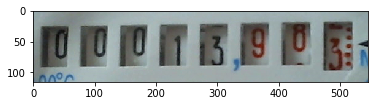

(116, 68, 3)
(116, 68, 3)
(116, 68, 3)
(116, 68, 3)
(116, 68, 3)
(116, 68, 3)
(116, 68, 3)
(116, 68, 3)
(116, 2, 3)


In [12]:
ind = 11
import re
name = './data/images/s11e00205.jpg'
_data = pd.read_csv('./data/labels/answers.csv', usecols=['markup'])
string = _data.loc[ind].values[0][36:-7]
data= list([int(i) for i in re.sub('\\D+', ' ', string).split(' ')[1:]])
image = plt.imread(name)
x, y, x1, y1 = data
img = image[y:y+y1, x:x+x1]
plt.imshow(img)
plt.show()
step = round(img.shape[1]/8)
for i in range(0, img.shape[1], step):
    print(img[:, i:i+step].shape)
    plt.show()

In [98]:
batch.indices

array(['s11e00051', 's01e00258', 's03e00036', 's10e00432', 's11e00205',
       's06e00426', 's04e00589', 's01e00309', 's03e00315', 's03e00230',
       's08e00174', 's06e00105', 's06e00882', 's06e00032', 's04e00610',
       's13e00702', 's10e00769', 's04e00214', 's04e00580', 's13e00771',
       's06e00094', 's06e00075', 's10e00665', 's10e00827', 's08e00058',
       's06e00030', 's13e00349', 's09e00887', 's04e00025', 's04e00047',
       's09e00921', 's09e00499', 's09e00534', 's11e00254', 's10e00732',
       's09e00817', 's09e00907', 's03e00339', 's13e00514', 's09e00575',
       's01e00206', 's09e00556', 's03e00276', 's04e00238', 's09e00519',
       's11e00324', 's10e00598', 's04e00992', 's13e00524', 's09e00615',
       's04e00234', 's04e00367', 's04e00979', 's13e00402', 's11e00072',
       's03e00285', 's08e00082', 's13e00823', 's06e00384', 's13e00490',
       's09e00380', 's01e00231', 's04e00940', 's10e00410', 's10e00594',
       's10e00611', 's13e00467', 's07e00035', 's04e00965', 's13e

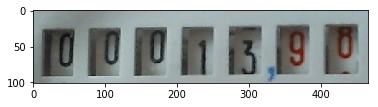

In [103]:
plt.imshow(batch.images[4])

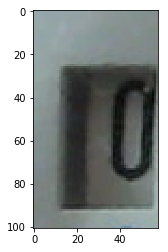

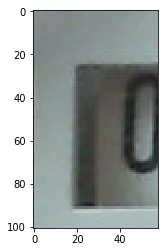

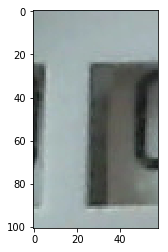

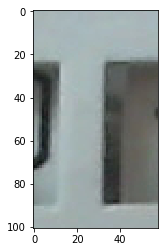

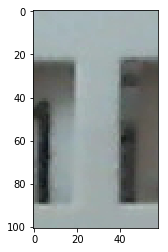

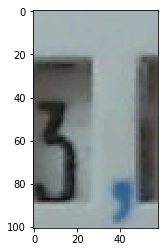

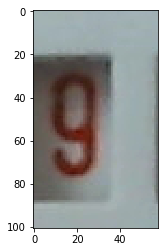

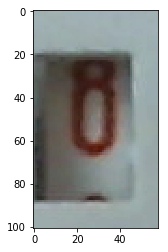

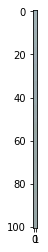

In [107]:
ind = 4
step = round(batch.images[ind].shape[1]/8)
for i in range(0, batch.images[ind].shape[1], step):
    plt.imshow(batch.images[ind][:, i:i+step])
    plt.show()

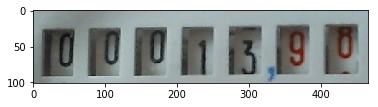

In [106]:
plt.imshow(batch.images[4])

In [8]:
plt.style.use("seaborn-poster")
ind = 8
plt.imshow(batch.images[ind])
plt.show()
x, y, x1, y1 = batch.coordinates[ind]
plt.imshow(batch.images[ind][y:y+y1, x:x+x1])
plt.title(batch.labels[ind])
plt.show()

IndexError: index 8 is out of bounds for axis 0 with size 1